# Proyecto I
## Formulación haciendo el mapeo conforme
### Caso Vacío

In [1]:
Atom = false
#Atom = true

false

In [2]:
using Gridap
using GridapODEs
if  Atom == false
    using GridapMakie, GLMakie
end
using FileIO
using GridapGmsh
using gmsh

In [3]:
Threads.nthreads()

7

In [4]:
model = GmshDiscreteModel("modelos/rectangleConf_NS.msh")

Info    : Reading 'modelos/rectangleConf_NS.msh'...
Info    : 9 entities
Info    : 30631 nodes
Info    : 61260 elements
Info    : Done reading 'modelos/rectangleConf_NS.msh'


UnstructuredDiscreteModel()

In [5]:
Ω = Triangulation(model)
degree = 3
dΩ = Measure(Ω,degree)

Measure()

In [6]:
writevtk(Ω,"square")

(["square.vtu"],)

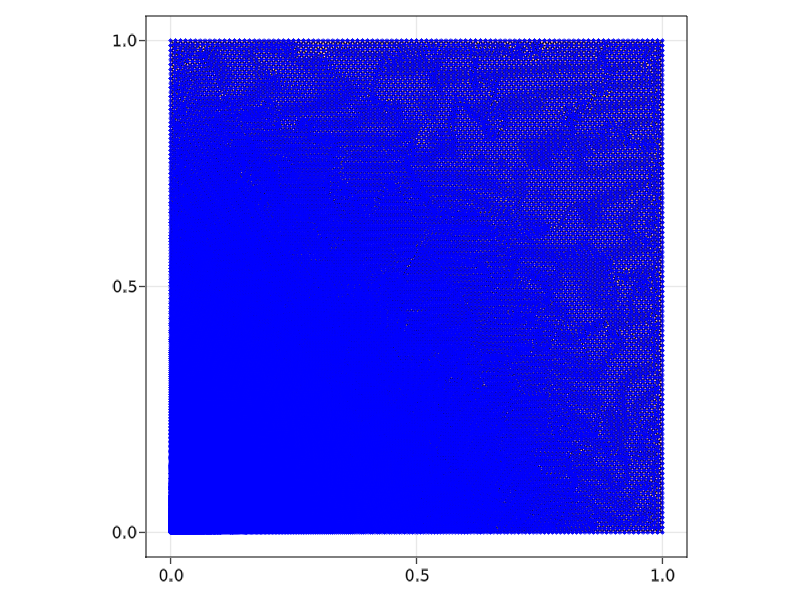

In [7]:
if Atom == false 
    fig, ax = plot(Ω)
    ax.aspect = AxisAspect(1) # this makes the region with fixed aspect, so it might not give the correct ratios
    wireframe!(Ω, color=:black, linewidth=1)
    scatter!(Ω, marker=:star8, markersize=4, color=:blue)
    fig
end 

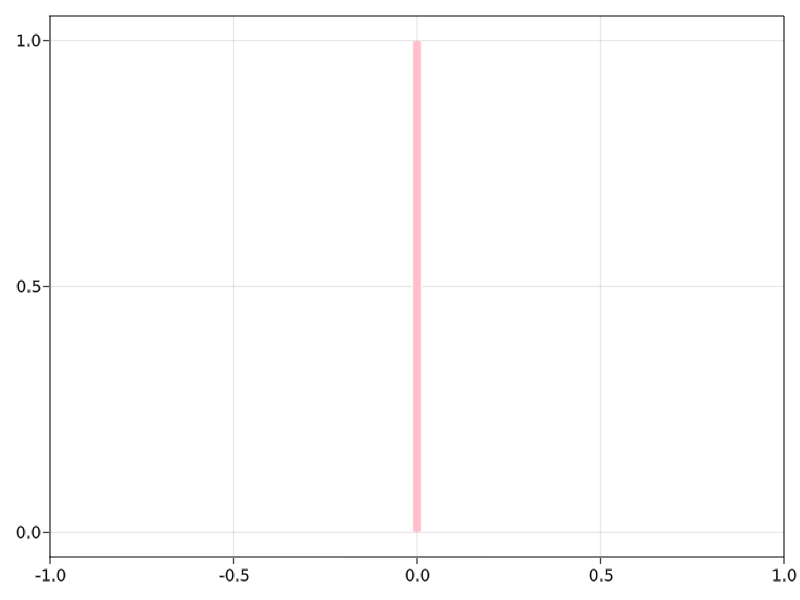

In [8]:
neumanntags_cx= ["centrorho"]
Γ_cx = BoundaryTriangulation(model,tags=neumanntags_cx)
dΓ_cx = Measure(Γ_cx,degree)
if Atom == false 
    fig = plot(Γ_cx, linewidth=8
    #, shading=true
    )
end

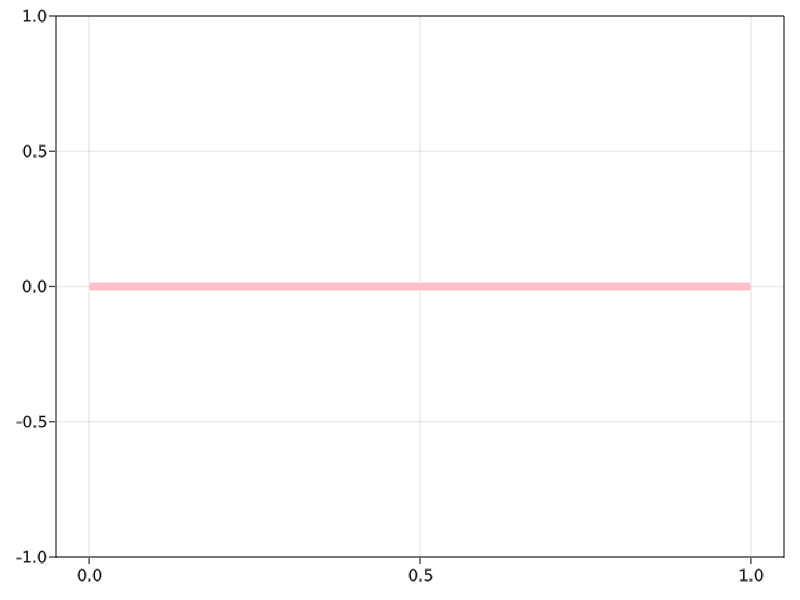

In [9]:
neumanntags_cy= [ "centroz"]
Γ_cy = BoundaryTriangulation(model,tags=neumanntags_cy)
dΓ_cy= Measure(Γ_cy,degree)
if Atom == false 
    fig = plot(Γ_cy, linewidth=8
    #, shading=true
      )
end

In [10]:
labels = get_face_labeling(model)
add_tag_from_tags!(labels,"ext",[ "asintrho","asintz"])

6-element Vector{String}:
 "centroz"
 "asintrho"
 "asintz"
 "centrorho"
 "surface"
 "ext"

In [11]:
order = 2
reffe = ReferenceFE(lagrangian,Float64,order)
V= TestFESpace(model,reffe,conformity=:H1,dirichlet_tags = ["ext"])
    #vector_type=Vector{Float64}
Uf = TrialFESpace(V,[0.])
Uλ = TrialFESpace(V,[1.])

TrialFESpace()

In [12]:
a0=6.0E-18
R=7.5E5
Z=7.3E5
ρH=10.0E5
zH=10.0E5
s(x) = sqrt(  ( (x[1] *ρH)/ ( R *(1. -x[1]) ) )^2 + ( (x[2] *zH )/ (Z*(1. -x[2])) )^2   ) 
q(x)=1. - s(x)^4 * (1. - 5. *(s(x) -1.) + 15. * (s(x) -1.)^2 - 35. *( s(x)-1.)^3 +70. * ( s(x)- 1.)^4)
 ##funcion de a partes que incluye a q
function α(x)
    if s(x) < 1.
        return q(x) *a0
        end
    if s(x)>= 1.
        return  0.
    end
end

function t(x)
  return 8. *π*α(x)
end

c(x)=0.

c (generic function with 1 method)

In [13]:
writevtk(Ω,"resultados/Proyecto1/NS-CONF/α",cellfields=["α"=>α])

(["resultados/Proyecto1/NS-CONF/α.vtu"],)

In [14]:
conv(l,∇t) = (∇t')⋅l

conv (generic function with 1 method)

In [16]:
function t5(x)
  return (2. * zH )/  (1. - x[2])^2
end

function t6(x)
  return (t(x)* ρH ^2 *x[1] * zH )/ ((1. - x[1])^3 * (1. - x[2])^2)
end

function t3(x)
  return (x[1]*(1. -x[1]) * zH) / (1 -x[2])^2
end

function t4(x)
  return ((1. - x[2])^2 *x[1] *ρH^2 )/ ( zH  *(1. - x[1])^3)
end

function t7(x)
  return (2 *π*α(x) *ρH^3 * x[1] ^2  *  zH )/ ((1. - x[1])^4 * (1. - x[2])^2)
end

function t8(x)
  return 3*t7(x) 
end

function t9(x)
  return (zH *x[1]^3 *ρH^4 )/ (4. * (1. - x[1])^5 * (1. - x[2])^2)
end

function t10(x)
  return 7*t9(x)
end

t10 (generic function with 1 method)

In [17]:
x1(x)= VectorValue(1,0)
x2(x)= VectorValue(0,1)

x2 (generic function with 1 method)

In [18]:
a(u,v) = ∫( -(x1 ⋅ ∇(u)) *(x1 ⋅ ∇(v))*t3 -(x2⋅ ∇(u))*(x2 ⋅ ∇(v))*t4  +   (x1 ⋅ ∇(u))*t5 * v ) *dΩ # en a(u,v) va toda la dependencia con u que es la incógnita. 

b(v) =∫(- v * t6) *dΩ +∫( c * v *t3 )*dΓ_cx +  ∫( c * v *t4)*dΓ_cy

b (generic function with 1 method)

In [19]:
op = AffineFEOperator(a,b,Uf,V)

AffineFEOperator()

In [20]:
ls = LUSolver()
solver = LinearFESolver(ls)

LinearFESolver()

In [21]:
uh = solve(solver,op)

SingleFieldFEFunction():
 num_cells: 60548
 DomainStyle: ReferenceDomain()
 Triangulation: BodyFittedTriangulation()
 Triangulation id: 17239856890660026494

In [22]:
writevtk(Ω,"resultados/Proyecto1/NS-CONF/f",cellfields=["uh"=>uh])
writevtk(Ω,"resultados/Proyecto1/NS-CONF/∇f",cellfields=["∇ uh"=>∇(uh)])

(["resultados/Proyecto1/NS-CONF/∇f.vtu"],)

In [34]:
x(x)=x[1]
y(x)=x[2]

y (generic function with 1 method)

In [37]:
f1=conv∘(x1,∇(uh))
f2=conv∘(x2,∇(uh))
F=f2*f2 +f1*f1

OperationCellField():
 num_cells: 60147
 DomainStyle: ReferenceDomain()
 Triangulation: BodyFittedTriangulation()
 Triangulation id: 9520895179885044127

In [38]:
writevtk(Ω,"resultados/VACIO-CONF/F",cellfields=["F"=>F])


(["resultados/VACIO-CONF/F.vtu"],)

In [51]:
res(w,w2)=  ∫(-(x1 ⋅ ∇(w)) *(x1 ⋅ ∇(w2))*t3 -(x2⋅ ∇(w))*(x2 ⋅ ∇(w2))*t4 + t7*w2/(w*w*w) + t9*F*w2/(w*w*w*w*w*w*w) )*dΩ+ ∫( c * w2 )  *dΓ_cy + ∫( c * w2 )  *dΓ_cx 

res (generic function with 1 method)

In [52]:
jac(w,dw,w2)=  ∫(-(x1 ⋅ ∇(dw)) *(x1 ⋅ ∇(w2))*t3 -(x2⋅ ∇(dw))*(x2 ⋅ ∇(w2))*t4 - t8*w2*dw/(w*w*w*w) -t10*F*dw*w2/(w*w*w*w*w*w*w*w) )*dΩ 

jac (generic function with 1 method)

In [53]:
ue(x)=1. + 1/(( (x[1]*ρH/(1. - x[1]))^2 + ( x[2]*zH /(1. -x[2]))^2 )^(1/2))

ue (generic function with 1 method)

In [54]:
oppsi = FEOperator(res,jac,Uλ,V)

FEOperatorFromWeakForm()

In [55]:
using LineSearches: BackTracking
nls = NLSolver(
  show_trace=true, method=:newton, linesearch=BackTracking(),ftol=1E-20, xtol= 1E-20)
solver = FESolver(nls)

NonlinearFESolver()

In [56]:
wseed=interpolate_everywhere(ue,Uλ)

SingleFieldFEFunction():
 num_cells: 60147
 DomainStyle: ReferenceDomain()
 Triangulation: BodyFittedTriangulation()
 Triangulation id: 9520895179885044127

In [57]:
writevtk(Ω,"resultados/VACIO-CONF/seedue",cellfields=["ue"=>ue])

(["resultados/VACIO-CONF/seedue.vtu"],)

In [58]:
w, = solve!(wseed,solver,oppsi)

Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     2.282646e+00              NaN
     1     1.696275e-02     7.668018e-06
     2     7.984750e-03     1.380086e-26
     3     8.229399e-03     9.135663e-27
     4     8.229399e-03     0.000000e+00


(SingleFieldFEFunction(), NLSolversCache())

In [59]:
 writevtk(Ω,"resultados/VACIO-CONF/Fact",cellfields=["ψ"=>w])

(["resultados/VACIO-CONF/Fact.vtu"],)